In [72]:
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import pandas as pd
import umap.umap_ as umap
import plotly.express as px
import numpy as np

In [73]:
def z_score(X):
    # X: ndarray, shape (n_features, n_samples)
    ss = StandardScaler(with_mean=True, with_std=True)
    Xz = ss.fit_transform(X)
    return Xz

In [74]:
d = pd.read_csv(r"doubleTrackData.csv")

data = d.dropna()

allGoodCol = data.columns
allGoodCol = list(allGoodCol)
allGoodCol = allGoodCol[5::]

nbExpT1 = len(data[(data["exposure"] == 1) & (data["track"] == 1)]["lap"].unique())
nbExpT2 = len(data[(data["exposure"] == 1) & (data["track"] == 2)]["lap"].unique())
nbReExpT1 = len(data[(data["exposure"] == 2) & (data["track"] == 1)]["lap"].unique())
nbReExpT2 = len(data[(data["exposure"] == 2) & (data["track"] == 2)]["lap"].unique())


print("Size is ", len(allGoodCol))
print("Nb of lap of the 1st track is", len(data[data["track"] == 1]["lap"].unique()))
print("Nb of lap of the 2nd track is", len(data[data["track"] == 2]["lap"].unique()))

# We can reduce the number of laps in RUN2 to 16
# print("Cropping Everything to : ", nbExpT2)
# data = data[~((data['lap'] > nbExpT2 + 1) & (data['exposure'] == 1))]
# data = data[~((data["lap"] > nbExpT2  + nbExpT2) & (data["exposure"] == 2) & (data["track"] == 2))]
# data = data[~((data["lap"] > nbExpT1 + nbExpT2) & (data["exposure"] == 2) & (data["track"] == 1))]

data.reset_index(drop=True, inplace=True)

Size is  148
Nb of lap of the 1st track is 50
Nb of lap of the 2nd track is 32


In [75]:
reducer = umap.UMAP(n_neighbors = 20, 
                    metric = 'cosine', 
                    output_metric = 'euclidean',
                    learning_rate = 1.0, 
                    init = 'spectral', 
                    min_dist = 0.1, 
                    spread = 1.0, 
                    repulsion_strength = 1.0,
                    negative_sample_rate = 5,
                    target_metric = 'categorical', 
                    dens_lambda = 2.0, 
                    dens_frac = 0.3,
                    dens_var_shift=0.1,
                    n_components = 3)

parsedData = data[allGoodCol].values

embedding = reducer.fit_transform(parsedData)
embedding.shape

(5540, 3)

In [76]:
df = pd.DataFrame(embedding, columns=['x1', 'x2', 'x3'])
df["x"] = data.x
df["lap"] = data.lap
df["speed"] = data.speed
df["track"] = data.track
df["exposure"] = data.exposure

In [77]:
fig = px.scatter_3d(df, x='x1', y='x2', z='x3',
              color='exposure', opacity=0.9)

fig.update_traces(marker_size=2)

# tight layout
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))
fig.show()

## Let's project the replay in there

In [78]:
# Load the replay data - MAKE SURE IT'S THE SAME ANIMAL !

dRep = pd.read_csv(r"replayDataDec.csv")
dataRep = dRep.dropna()
allGoodColRep = dataRep.columns
allGoodColRep = list(allGoodColRep)
allGoodColRep = allGoodColRep[3::]


In [79]:
parsedDataRep = dataRep[allGoodCol].values
embeddingRep = reducer.transform(parsedDataRep)

In [80]:
dfRep = pd.DataFrame(embeddingRep, columns=['x1', 'x2', 'x3'])
dfRep["t"] = dRep["binEdges"]
dfRep["order"] = dRep["order"]

In [81]:
import plotly.graph_objects as go

In [82]:
fig = go.Figure(data=[go.Scatter3d(x=df["x1"], y=df["x2"], z = df["x3"], mode='markers')])

fig.add_trace(go.Scatter3d(x=dfRep["x1"], y=dfRep["x2"], z=dfRep["x3"], mode='markers'))
fig.update_traces(marker_size=2)

# tight layout
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))
fig.show()

## We try to decode the track / exposure of each reactivation

### Decoded value = value of the nearest neighbor

In [83]:
from scipy.spatial import distance

# For each point in the replay, we want to find the closest point in the original data - exposure == 2

distMat = distance.cdist(embeddingRep, embedding, 'euclidean')

# We find the index of the minimum on each line
minIndex = np.argmin(distMat, axis = 1)

# We can now decode the variables

# Now we retrieve the position of the closest point
x = df["x"].values
dfRep["x"] = x[minIndex]

# We retrieve the exposure of the closest point
exposure = df["exposure"].values
dfRep["exposure"] = exposure[minIndex]

# We retrieve the lap of the closest point
lap = df["lap"].values
dfRep["lap"] = lap[minIndex]

# We retrieve the track of the closest point
track = df["track"].values
dfRep["track"] = track[minIndex]

Text(0.5, 0, 'Lap (cm)')

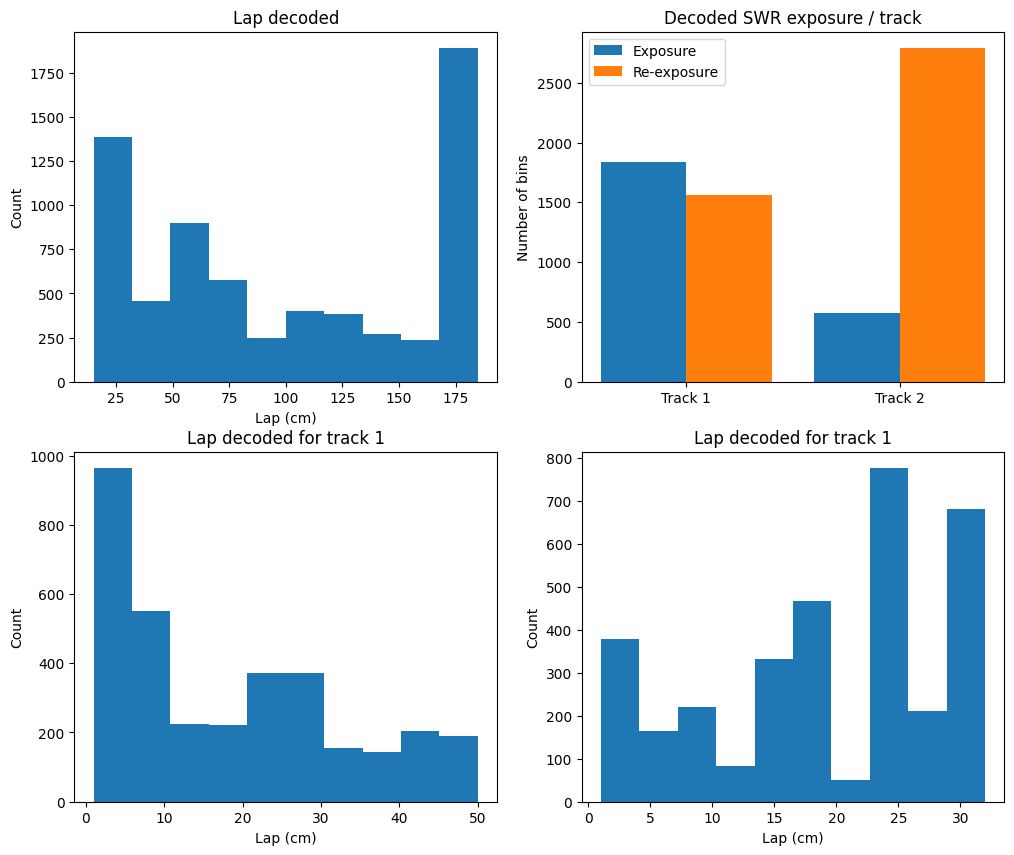

In [84]:
# Are the Lap decoded paving the tracks ?

plt.figure(figsize=(12, 10))  # Increase the width to 12 inches and height to 6 inches

plt.subplot(2, 2, 1)
plt.hist(dfRep["x"])
plt.title("Lap decoded")
plt.ylabel("Count")
plt.xlabel("Lap (cm)")

# Do we see that track 2 is less replayed than track 1 ? Do we see a replay of the re-exposure for each ?

plt.subplot(2, 2, 2)

nbRepExpT1 = len(dfRep["exposure"][(dfRep["track"] == 1) & (dfRep["exposure"] == 1)])
nbRepReExpT1 = len(dfRep["exposure"][(dfRep["track"] == 1) & (dfRep["exposure"] == 2)])
nbRepExpT2 = len(dfRep["exposure"][(dfRep["track"] == 2) & (dfRep["exposure"] == 1)])
nbRepReExpT2 = len(dfRep["exposure"][(dfRep["track"] == 2) & (dfRep["exposure"] == 2)])

# Define the labels for the bars
labels = ['Track 1', 'Track 2']

# Define the heights of the bars
left_bars = [nbRepExpT1, nbRepExpT2]
right_bars = [nbRepReExpT1, nbRepReExpT2]

# Define the Laps for the bars on the x-axis
x = np.arange(len(labels))
rects1 = plt.bar(x - 0.2, left_bars, 0.4, label='Exposure')
rects2 = plt.bar(x + 0.2, right_bars, 0.4, label='Re-exposure')

# Add labels, title and custom x-axis tick labels, etc.
plt.ylabel('Number of bins')
plt.title('Decoded SWR exposure / track')
plt.xticks(x, labels)
plt.legend()

plt.subplot(2, 2, 3)
plt.hist(dfRep[dfRep["track"] == 1]["lap"])
plt.title("Lap decoded for track 1")
plt.ylabel("Count")
plt.xlabel("Lap (cm)")

plt.subplot(2, 2, 4)
plt.hist(dfRep[dfRep["track"] == 2]["lap"])
plt.title("Lap decoded for track 2")
plt.ylabel("Count")
plt.xlabel("Lap (cm)")



### For this plot to have sense, need to have the same number of points of each track / exposure !

In [85]:
np.corrcoef(dRep["id"], dfRep["exposure"])

array([[1.        , 0.04184388],
       [0.04184388, 1.        ]])